In [1]:
import sys
sys.path.append("../")
import numpy as np
from sanchez_ansatz import SanchezAnsatz
from qiskit import transpile
import matplotlib.pyplot as plt

##### Circuito quântico parametrizado no Qiskit

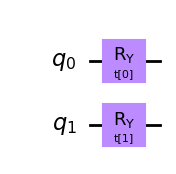

In [2]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter


example_circ = QuantumCircuit(2)

example_circ.ry(Parameter("t[0]"), 0)
example_circ.ry(Parameter("t[1]"), 1)
example_circ.draw("mpl")

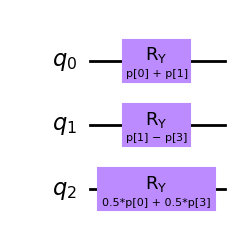

In [3]:
p0, p1, p2 = Parameter("p[0]"), Parameter("p[1]"), Parameter("p[3]")

example_circ = QuantumCircuit(3)
example_circ.ry(p0 + p1, 0)
example_circ.ry(p1 - p2, 1)
example_circ.ry(0.5*p0 + 0.5*p2, 2)
display(example_circ.draw("mpl"))

In [4]:
example_circ.parameters

ParameterView([Parameter(p[0]), Parameter(p[1]), Parameter(p[3])])

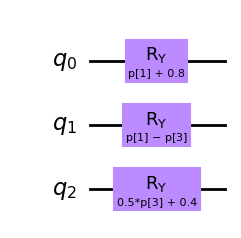

In [5]:
example_circ.assign_parameters({p0: 0.8}, inplace=True)
example_circ.draw("mpl")

In [6]:
example_circ.parameters

ParameterView([Parameter(p[1]), Parameter(p[3])])

##### Aproximando estados quânticos utilizando circuitos qânticos variacionais

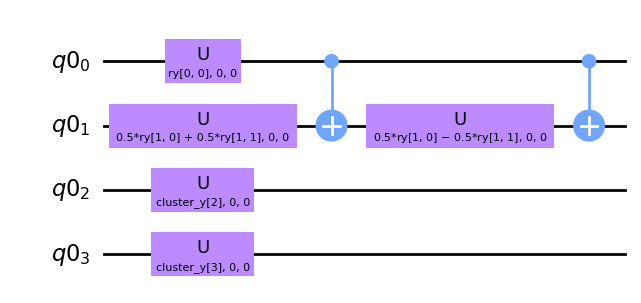

In [7]:
# Hyperparams
num_qubits = 4
eps = 0.3

# building target state
target_state = np.random.rand(2**num_qubits)
target_state = target_state / np.linalg.norm(target_state)
target_state = target_state

# creating circuit
circuit = SanchezAnsatz(target_state, eps)
init_params = circuit.init_params

t_circuit = transpile(circuit, basis_gates=["u", "cx"])
t_circuit.draw("mpl")

Utilizando funções

In [8]:
from qiskit_aer import Aer
from qiskit_algorithms.optimizers import SPSA

def run_experiment(ansatz, x0):
    sv_sim = Aer.get_backend("statevector_simulator")

    loss_history = []

    def callback(value):
        loss_history.append(value)

    def objective_fn(x):
        # extracting statevector data
        temp_ansatz = ansatz.assign_parameters(x)
        job = sv_sim.run(temp_ansatz)
        result = job.result()
        statevector = result.get_statevector()
        sv_data = statevector.data

        #computing loss
        fid_loss = 1 - np.abs(target_state @ sv_data) ** 2
        
        callback(fid_loss)
        
        return fid_loss

    optimizer = SPSA()
    result = optimizer.minimize(fun=objective_fn, x0=x0)
    return result, loss_history

In [9]:
result_original, history_original = run_experiment(t_circuit, init_params)

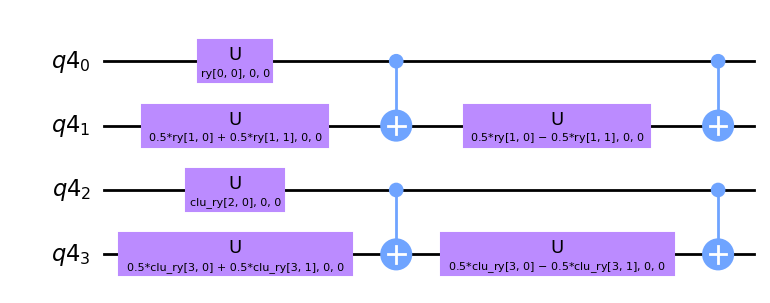

In [10]:
mod_circuit = SanchezAnsatz(target_state, eps, build_modified=True)
mod_init_params = mod_circuit.init_params

t_mod = transpile(mod_circuit, basis_gates=['cx', 'u'])
display(t_mod.draw("mpl"))

result_modified, history_modified = run_experiment(t_mod, mod_init_params)

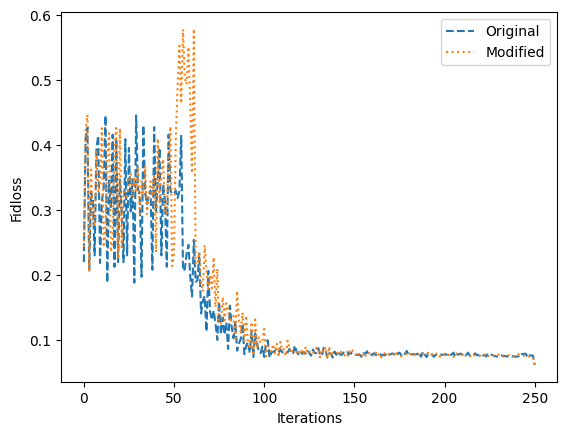

In [11]:
plt.plot(history_original, "--", label="Original")
plt.plot(history_modified, ":", label="Modified")
plt.ylabel("Fidloss")
plt.xlabel("Iterations")
plt.legend(loc="best")
plt.show()

Utilizando POO

In [12]:
class ExperimentModule: 

    def __init__(
            self,
            ansatz, 
            init_params,
            target_state,
            optimizer=None, 
            backend=None, 
            callback=None):
        self._ansatz = ansatz
        self._init_params = init_params
        self._target_state = target_state
        self._callback = callback

        if optimizer is None:
            self._optimizer = SPSA()
        else: 
            self._optimizer = optimizer
        
        if backend is None: 
            self._backend = Aer.get_backend("statevector_simulator")
        else: 
            self._backend = backend

    
    def objective_fn(self, x):
        # extracting statevector data
        temp_ansatz = self._ansatz.assign_parameters(x)
        job = self._backend.run(temp_ansatz)
        result = job.result()
        statevector = result.get_statevector()
        sv_data = statevector.data

        #computing loss
        fid_loss = 1 - np.abs(target_state @ sv_data) ** 2
        
        if self._callback is not None:
            self._callback(fid_loss)
        
        return fid_loss

    def minimize(self):
        
        return self._optimizer.minimize(
                                    fun=self.objective_fn,
                                    x0=self._init_params
                                )

In [13]:
og_loss_history = []
def custom_callback(value): 
    og_loss_history.append(value)

em = ExperimentModule(t_circuit, init_params, target_state, callback=custom_callback)
em.minimize()

In [14]:
em._ansatz = t_mod
em._init_params = mod_init_params

mod_loss_history = []
def custom_callback(value): 
    mod_loss_history.append(value)

em._callback = custom_callback

em.minimize()

In [18]:
from types import MethodType

def custom_objective_fn(self, x):
    # extracting statevector data
    temp_ansatz = self._ansatz.assign_parameters(x)
    job = self._backend.run(temp_ansatz)
    result = job.result()
    statevector = result.get_statevector()
    sv_data = statevector.data.astype(np.float32)

    return np.mean(np.power(self._target_state - sv_data, 2))

em.objective_fn = MethodType(custom_objective_fn, em)
em.minimize()

/tmp/ipykernel_15880/2257862706.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  sv_data = statevector.data.astype(np.float32)
